190501V

Ranathunga R.A.C.D.
                                                    
Github profile : https://github.com/ChamithDilshan




In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [5]:
s = open('templeSparseRing/templeSR_par.txt','r')
assert s is not None
n = int(s.readline())

l = s.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

l = s.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

im1 = cv.imread('templeSparseRing/'+ im1_fn, cv.IMREAD_COLOR) ; assert im1 is not None
im2 = cv.imread('templeSparseRing/'+ im2_fn, cv.IMREAD_COLOR) ; assert im2 is not None

In [6]:
sift = cv.xfeatures2d.SIFT_create()

kp1,desc1 = sift.detectAndCompute(im1,None)
kp2,desc2 = sift.detectAndCompute(im2,None)

FLANN_INDEX_KDTREF = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREF,trees = 5)
search_params = dict(checks=100)

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(desc1,desc2, k = 2)

good = []
pts1 = []
pts2 = []

for i,(m,n) in enumerate (matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

for i,(m,n) in enumerate (matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

f,mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)
E = K2.T @ f @ K1

In [7]:
retval,R,t,mask = cv.recoverPose(E,pts1,pts2,K1)

R_t_1 = np.concatenate((R1,t1),axis = 1)
R_t_2 = np.empty((3,4))
R2_ = R1@R
t2_ = R1@t
R_t_2 = np.concatenate((R2_,t2_),axis = 1)

P1 = K1 @ np.hstack((R1,t1)) 
P2_ = K2 @ R_t_2

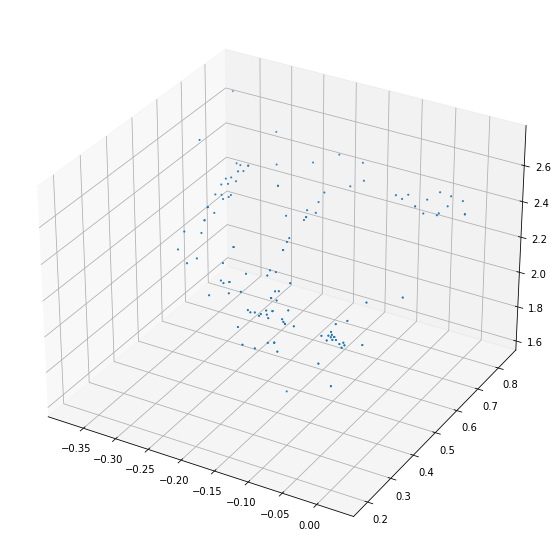

In [13]:
points4d = cv.triangulatePoints(P1,P2_,pts1.T,pts2.T)
points4d /= points4d[3,:]

x = points4d[0,:]
y = points4d[1,:]
z = points4d[2,:]

figure = plt.figure(figsize=(10,10))
ax = figure.add_subplot(111,projection = '3d')
ax.scatter(x,y,z,s = 1,cmap = 'gray')
plt.show()
